# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
#from watchmal.testing.repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("../..")
sys.path.append("..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython.display import HTML

## Load Data

In [2]:
# Import test events from h5 file

original_data_path = "/data/WatChMaL/data/IWCD_mPMT_Short_e-mu-gamma_E0to1000MeV_digihits.h5"
data_file = h5py.File(original_data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(original_data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(original_data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

#original_radius = [np.sqrt(original_positions[i,0,0]**2 + original_positions[i,0,2]**2) for i in range(original_positions.shape[0])]


<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


## Split Datasets

In [3]:
idxs_path = '/home/jtindall/WatChMaL_analysis/short_tank_exploratory_data_analysis/new_dataset/new_dataset_data/equal_indices.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

In [4]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels}

print("Done test info")


Done train info
Done val info
Done test info


In [5]:
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])
"""

"\ntrain_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]\nval_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]\ntest_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]\n\nnp.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])\n"

In [6]:
f = np.load('./new_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = f['train_radii']
val_info['radius']   = f['val_radii']
test_info['radius']  = f['test_radii']

In [7]:
dataset_info = [train_info,val_info,test_info]

# Initialize Event Parameters

In [8]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Hit Charge by PMT

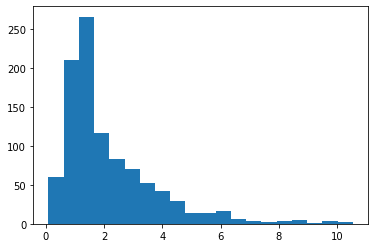

In [13]:
plt.hist(hit_charge[0:1000], bins=20)
plt.show()

In [17]:
pmt_charge = []

pbar = ProgressBar(widgets=['Calculating PMT Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(val_idxs))

pbar.start()
# fetch data for first 1000 events

random_indices = np.random.choice(val_idxs, size=100000, replace=False)
for i in random_indices:
    pbar.update(i)
    
    item = i #val_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    #print(charge)
    pmt_charge.extend(charge)
    #print(pmt_charge[0])
    #input()
pbar.finish()

dataset_info[1]['pmt_charge'] = np.array(pmt_charge)

np.savez('./new_dataset_data/validation_set_pmt_charge.npz', pmt_charge=dataset_info[1]['pmt_charge'])

KeyboardInterrupt: 

In [15]:
print(len(val_idxs))

884548


# Hit Times

In [10]:
print(hdf5_hit_time.shape)

(29861628065,)


In [ ]:
# randomly select 5 events

# Hit Time for Max Charge PMT

# 